In [ ]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import requests
import time
from sklearn.metrics import accuracy_score
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pd.to_datetime([2010, 1, 1], unit='s')

DatetimeIndex(['1970-01-01 00:33:30', '1970-01-01 00:00:01',
               '1970-01-01 00:00:01'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
lat = 54.99244
lon = 73.36859
struct_start = time.strptime('01/01/2010 00:00', '%d/%m/%Y %H:%M')
start = int(time.mktime(struct_start))
struct_end = time.strptime('01/05/2022 00:00', '%d/%m/%Y %H:%M')
end = int(time.mktime(struct_end))
API_key = '8b80be6752e41043bc234842ac8a4bb3'
air_polution_data = requests.get(f'http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={API_key}')

In [ ]:
json_data = air_polution_data.json()
len(json_data)

2

In [ ]:
time_steps = []
aqis = []
for elem in json_data['list']:
  time_steps.append(elem['dt'])
  aqis.append(elem['main']['aqi'])

In [ ]:
index_time = pd.to_datetime(time_steps, unit='s')
df = pd.DataFrame(index=index_time, columns=['aqi'])
df['aqi'] = aqis
df.head()

,aqi
2020-11-25 01:00:00,1
2020-11-25 02:00:00,1
2020-11-25 03:00:00,1
2020-11-25 04:00:00,1
2020-11-25 05:00:00,1


In [ ]:
df.to_csv('air_pol.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12456 entries, 2020-11-25 01:00:00 to 2022-05-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   aqi     12456 non-null  int64
dtypes: int64(1)
memory usage: 194.6 KB


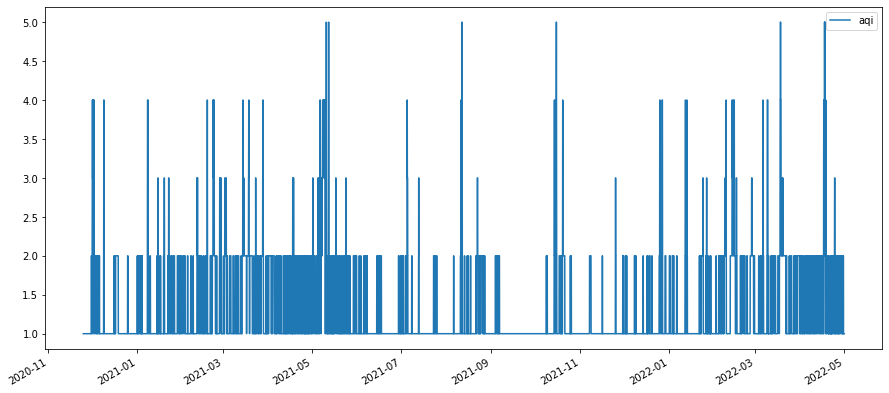

In [ ]:
df.plot(figsize=(15,7))

In [ ]:
print(df.index.freq)

None


In [ ]:
df = df.asfreq('H')

In [ ]:
df[df["aqi"].isnull()] = float(round(df.aqi.mean()))

In [ ]:
df.aqi

2020-11-25 01:00:00    1.0
2020-11-25 02:00:00    1.0
2020-11-25 03:00:00    1.0
2020-11-25 04:00:00    1.0
2020-11-25 05:00:00    1.0
                      ... 
2022-04-30 20:00:00    1.0
2022-04-30 21:00:00    1.0
2022-04-30 22:00:00    1.0
2022-04-30 23:00:00    1.0
2022-05-01 00:00:00    1.0
Freq: H, Name: aqi, Length: 12528, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12528 entries, 2020-11-25 01:00:00 to 2022-05-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aqi     12528 non-null  float64
dtypes: float64(1)
memory usage: 195.8 KB


In [ ]:
df.index

DatetimeIndex(['2020-11-25 01:00:00', '2020-11-25 02:00:00',
               '2020-11-25 03:00:00', '2020-11-25 04:00:00',
               '2020-11-25 05:00:00', '2020-11-25 06:00:00',
               '2020-11-25 07:00:00', '2020-11-25 08:00:00',
               '2020-11-25 09:00:00', '2020-11-25 10:00:00',
               ...
               '2022-04-30 15:00:00', '2022-04-30 16:00:00',
               '2022-04-30 17:00:00', '2022-04-30 18:00:00',
               '2022-04-30 19:00:00', '2022-04-30 20:00:00',
               '2022-04-30 21:00:00', '2022-04-30 22:00:00',
               '2022-04-30 23:00:00', '2022-05-01 00:00:00'],
              dtype='datetime64[ns]', length=12528, freq='H')

Критерий Д-Ф: p=0.000000


<Figure size 1080x576 with 0 Axes>

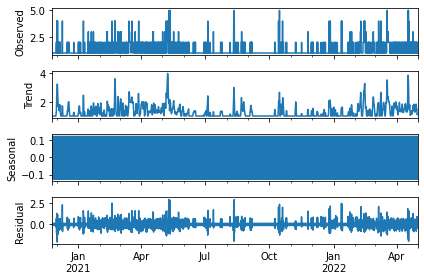

In [ ]:
plt.figure(figsize=(15,8))
sm.tsa.seasonal_decompose(df.aqi).plot()
print('Критерий Д-Ф: p=%f' % sm.tsa.stattools.adfuller(df.aqi)[1])

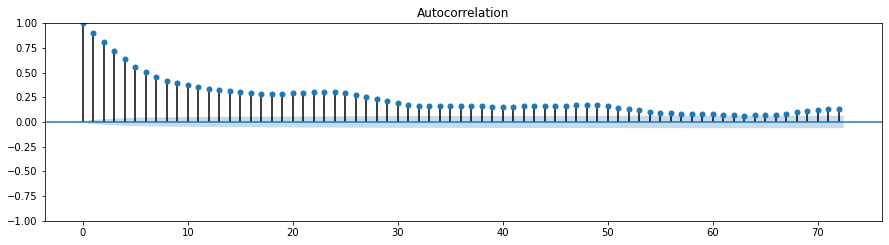

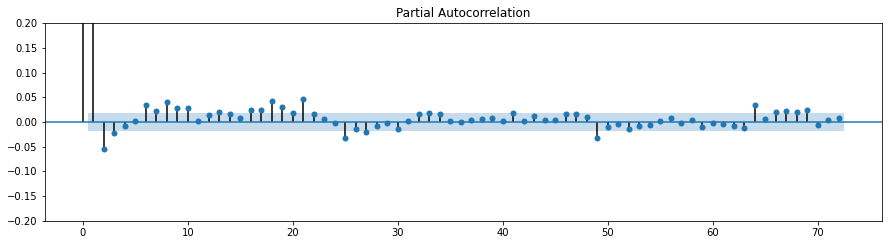

In [ ]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.aqi.values.squeeze(), lags=72, ax=ax)
plt.ylim([-1, 1])
plt.show()

plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.aqi.values.squeeze(), lags=72, ax=ax)
plt.ylim([-0.2, 0.2])
plt.show()

По диаграмме автокорреляции можно заметить начилие тренда, произведем дифференцирование

Критерий ДФ: p=0.000000


<Figure size 1080x720 with 0 Axes>

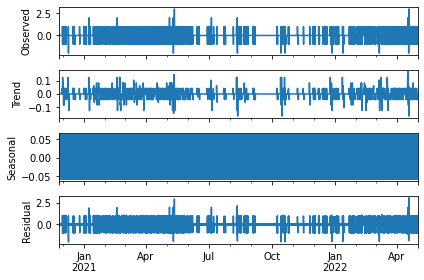

In [ ]:
plt.figure(figsize=(15,10))
df['aqi_T'] = df.aqi - df.aqi.shift(1)
sm.tsa.seasonal_decompose(df.aqi_T[1:]).plot()
print('Критерий ДФ: p=%f' % sm.tsa.stattools.adfuller(df.aqi_T[1:])[1])

По критерию Дики-Фуллера получаем, что временной ряд стационарный, тогда для модели SARIMA будем считать, что $d=1, D=0$.

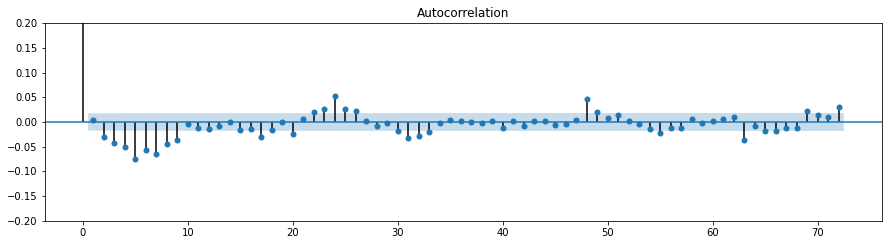

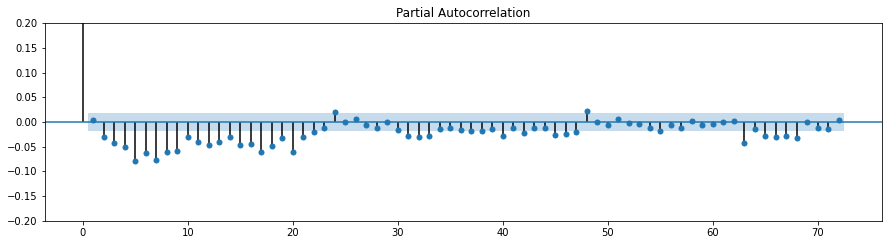

In [ ]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.aqi_T[1:].values.squeeze(), lags=72, ax=ax)
plt.ylim([-0.2, 0.2])
plt.show()

plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.aqi_T[1:].values.squeeze(), lags=72, ax=ax)
plt.ylim([-0.2, 0.2])
plt.show()

Определим по графикам автокорреляции и частичной автокорреляции верхние границы значений $Q = 0 , q = 9, P = 0, p = 20$

In [ ]:
p = range(0,20)
P = range(0,1)
q = range(0, 9)
Q = range(0,1)
d = 1 #range(0,2)
D = 0

In [ ]:
parametrs = list(product(p,q,P,Q))
print(len(parametrs))
print(parametrs[1])

180
(0, 1, 0, 0)


In [ ]:
%%time
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parametrs:
  model = sm.tsa.statespace.SARIMAX(df.aqi, order=(param[0], d, param[1]),
                                    seasonal_order=(param[2], D, param[3], 0)).fit(disp=-1)

  aic = model.aic
  
  if aic < best_aic:
    best_model = model
    best_aic = aic
    best_param = param
  results.append([param, model.aic])
warnings.filterwarnings('default')

CPU times: user 2h 47min 19s, sys: 2h 1min 14s, total: 4h 48min 33s
Wall time: 2h 28min 52s


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parametrs', 'aic']
print(result_table.sort_values(by='aic', ascending=True)[:5])

         parametrs          aic
172  (19, 1, 0, 0)  1410.695454
163  (18, 1, 0, 0)  1417.815870
173  (19, 2, 0, 0)  1420.911373
174  (19, 3, 0, 0)  1425.190791
175  (19, 4, 0, 0)  1433.375840


Обучим лучшую модель (для перезапуска блокнота)

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(df.aqi, order=(19, d, 1),
                                    seasonal_order=(0, D, 0, 0)).fit(disp=-1)

In [ ]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                    aqi   No. Observations:                12528
Model:              SARIMAX(19, 1, 1)   Log Likelihood                -684.348
Date:                Sun, 22 May 2022   AIC                           1410.695
Time:                        09:02:39   BIC                           1566.844
Sample:                    11-25-2020   HQIC                          1462.964
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9414      0.006    145.361      0.000       0.929       0.954
ar.L2         -0.0336      0.008     -3.959      0.000      -0.050      -0.017
ar.L3         -0.0125      0.008     -1.559      0.1

Критерий Стьюдента: p=0.642592
Критерий ДФ: p=0.000000


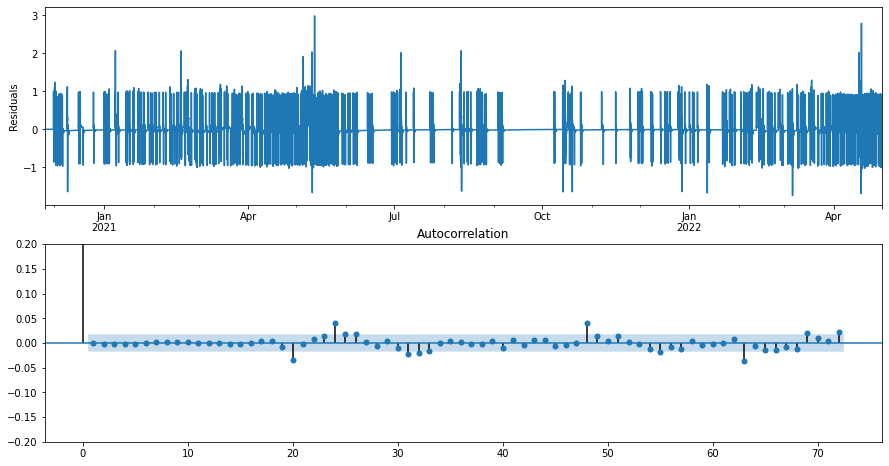

In [ ]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=72, ax=ax)
plt.ylim([-0.2, 0.2])

print('Критерий Стьюдента: p=%f' % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print('Критерий ДФ: p=%f' % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

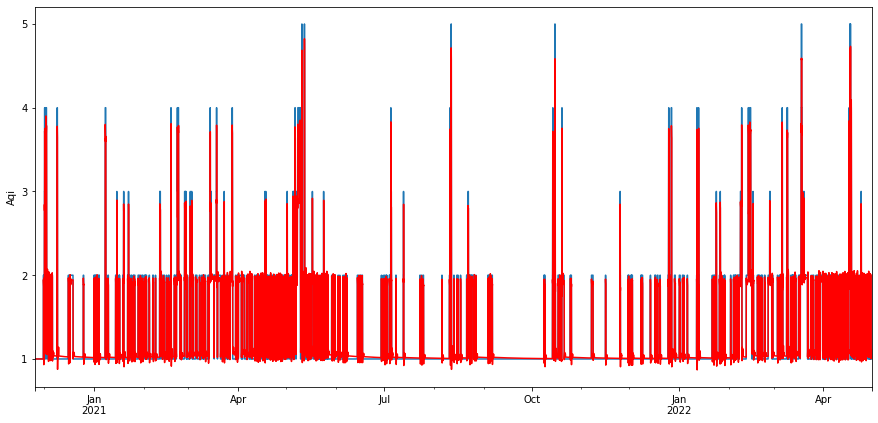

In [ ]:
df['model'] = best_model.fittedvalues
plt.figure(figsize(15,7))
df.aqi.plot()
df.model[1:].plot(color='r')
plt.ylabel('Aqi')
plt.show()

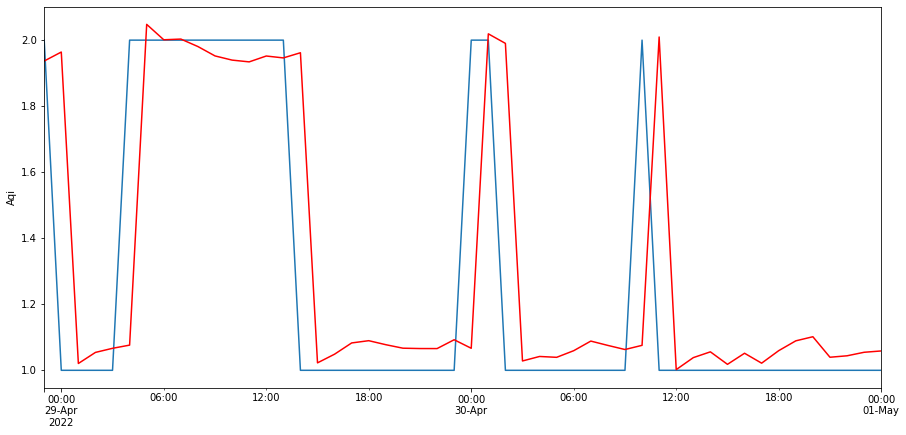

In [ ]:
plt.figure(figsize(15,7))
df.aqi[-50:].plot()
df.model[-50:].plot(color='r')
plt.ylabel('Aqi')
plt.show()

Составим предсказания и проверим их на оставшейся выборке

In [ ]:
months = pd.date_range('2022-05-01', '2022-05-10', freq='H')
future= pd.DataFrame(index=months, columns=df.columns)
future['forecast'] = best_model.predict(start=12528,end=12744)
future['forecast_round'] = round(best_model.predict(start=12528,end=12744))

In [ ]:
lat = 54.99244
lon = 73.36859
struct_start = time.strptime('01/05/2022 00:00', '%d/%m/%Y %H:%M')
start = int(time.mktime(struct_start))
struct_end = time.strptime('10/05/2022 00:00', '%d/%m/%Y %H:%M')
end = int(time.mktime(struct_end))
API_key = '8b80be6752e41043bc234842ac8a4bb3'
air_polution_data_fut = requests.get(f'http://api.openweathermap.org/data/2.5/air_pollution/history?lat={lat}&lon={lon}&start={start}&end={end}&appid={API_key}')

In [ ]:
json_data = air_polution_data_fut.json()

In [ ]:
time_steps = []
aqis = []
for elem in json_data['list']:
  time_steps.append(elem['dt'])
  aqis.append(elem['main']['aqi'])

In [ ]:
future['aqi'] = aqis
future.head()

,aqi,forecast,forecast_round
2022-05-01 00:00:00,1,NaN,NaN
2022-05-01 01:00:00,1,1.035129,1.0
2022-05-01 02:00:00,1,1.083952,1.0
2022-05-01 03:00:00,1,1.110623,1.0
2022-05-01 04:00:00,1,1.162154,1.0


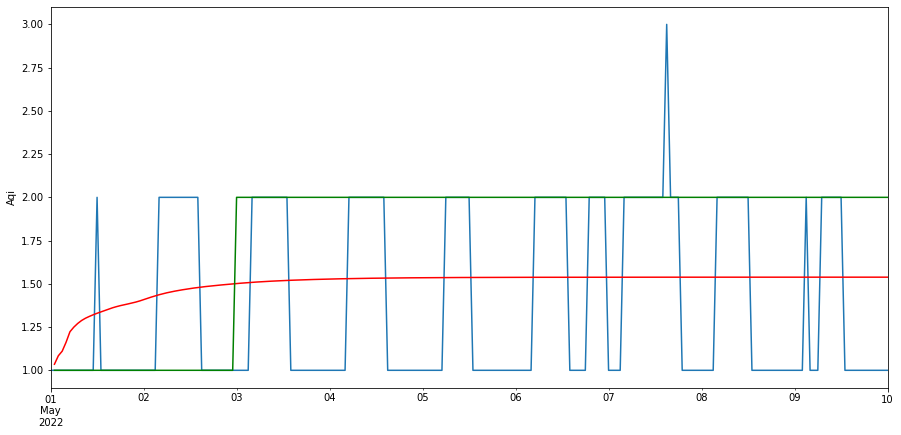

In [ ]:
plt.figure(figsize=(15,7))
future.aqi.plot()
future.forecast.plot(color='r')
future.forecast_round.plot(color='g')
plt.ylabel('Aqi')
plt.show()

In [ ]:
print("Accuracy of forecasts", accuracy_score(future['aqi'][1:], future['forecast_round'][1:]))

Accuracy of forecasts 0.49074074074074076


In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(future['aqi'][1:], future['forecast_round'][1:])

0.5092592592592593

#Нейронка

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:

time_train = df.index
x_train = np.array(df['aqi']) #to_cat(np.array(df['aqi']))
time_valid = future.index[1:]
x_valid = np.array(future['aqi'][1:]) #to_cat(np.array(future['aqi'][1:])) 

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
np.random.seed(51)
tf.keras.backend.clear_session()
tf.random.set_seed(51)


window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
              

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
98/98 [==============================] - 21s 39ms/step - loss: 17.1718 - mae: 17.6679 - lr: 1.0000e-08
Epoch 2/100
98/98 [==============================] - 4s 36ms/step - loss: 15.8213 - mae: 16.3163 - lr: 1.1220e-08
Epoch 3/100
98/98 [==============================] - 4s 36ms/step - loss: 14.5206 - mae: 15.0151 - lr: 1.2589e-08
Epoch 4/100
98/98 [==============================] - 4s 35ms/step - loss: 13.3312 - mae: 13.8260 - lr: 1.4125e-08
Epoch 5/100
98/98 [==============================] - 4s 35ms/step - loss: 12.2926 - mae: 12.7868 - lr: 1.5849e-08
Epoch 6/100
98/98 [==============================] - 4s 35ms/step - loss: 11.4229 - mae: 11.9153 - lr: 1.7783e-08
Epoch 7/100
98/98 [==============================] - 4s 35ms/step - loss: 10.7075 - mae: 11.1998 - lr: 1.9953e-08
Epoch 8/100
98/98 [==============================] - 4s 36ms/step - loss: 10.1075 - mae: 10.5997 - lr: 2.2387e-08
Epoch 9/100
98/98 [==============================] - 4s 36ms/step - loss: 9.5724 - mae:

(1e-08, 0.0001, 0.0, 30.0)

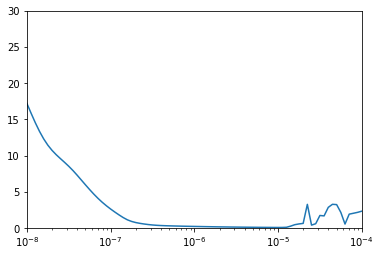

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


history = model.fit(dataset,epochs=100)


Epoch 1/100
390/390 [==============================] - 25s 23ms/step - loss: 0.7058 - mae: 0.9869
Epoch 2/100
390/390 [==============================] - 7s 19ms/step - loss: 0.0772 - mae: 0.2616
Epoch 3/100
390/390 [==============================] - 7s 19ms/step - loss: 0.0647 - mae: 0.2281
Epoch 4/100
390/390 [==============================] - 5s 12ms/step - loss: 0.0578 - mae: 0.2086
Epoch 5/100
390/390 [==============================] - 5s 11ms/step - loss: 0.0529 - mae: 0.1943
Epoch 6/100
390/390 [==============================] - 5s 13ms/step - loss: 0.0491 - mae: 0.1821
Epoch 7/100
390/390 [==============================] - 6s 14ms/step - loss: 0.0469 - mae: 0.1753
Epoch 8/100
390/390 [==============================] - 5s 11ms/step - loss: 0.0450 - mae: 0.1683
Epoch 9/100
390/390 [==============================] - 5s 11ms/step - loss: 0.0434 - mae: 0.1624
Epoch 10/100
390/390 [==============================] - 5s 12ms/step - loss: 0.0424 - mae: 0.1583
Epoch 11/100
390/390 [======

In [ ]:
rnn_forecast = model_forecast(model, x_train[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[0:-1, -1, 0]

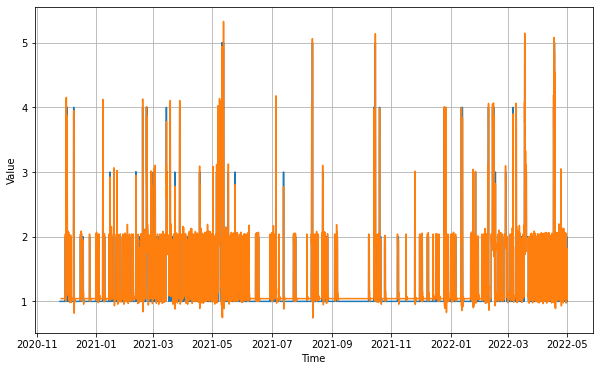

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plot_series(time_train[window_size:], rnn_forecast)

In [ ]:
future['aqi'][1:]

2022-05-01 01:00:00    1
2022-05-01 02:00:00    1
2022-05-01 03:00:00    1
2022-05-01 04:00:00    1
2022-05-01 05:00:00    1
                      ..
2022-05-09 20:00:00    1
2022-05-09 21:00:00    1
2022-05-09 22:00:00    1
2022-05-09 23:00:00    1
2022-05-10 00:00:00    1
Freq: H, Name: aqi, Length: 216, dtype: int64

In [ ]:
rnn_forecast_val = model_forecast(model, x_valid[..., np.newaxis], window_size)
rnn_forecast_val = rnn_forecast_val[0:-1, -1, 0]

In [ ]:
mean_absolute_error(x_valid[-156:], rnn_forecast_val)

0.1835930851789621

In [ ]:
accuracy_score(x_valid[-156:], np.round(rnn_forecast_val))

0.8782051282051282

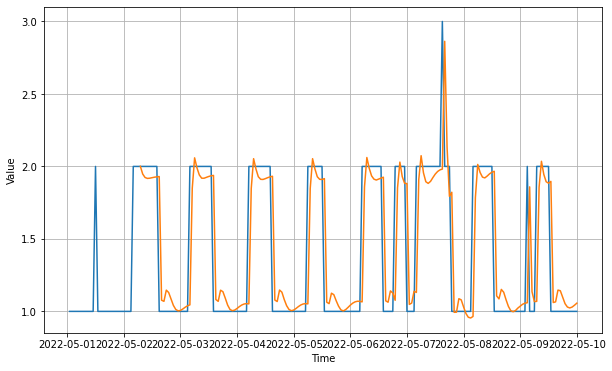

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid[window_size:], rnn_forecast_val)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model_2 = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, input_shape=[None, 1], return_sequences=True),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.Dense(128, activation="relu"),
tf.keras.layers.Dense(128, activation="relu"),
tf.keras.layers.LSTM(32, return_sequences=True),
tf.keras.layers.LSTM(32, return_sequences=True),
tf.keras.layers.Dense(64, activation="relu"),
tf.keras.layers.Dense(32, activation="relu"),
tf.keras.layers.Dense(1, activation="relu"),
tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model_2.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer,
metrics=["mae"])
history = model_2.fit(dataset,epochs=100)

Epoch 1/100
98/98 [==============================] - 9s 31ms/step - loss: 0.1971 - mae: 0.4691
Epoch 2/100
98/98 [==============================] - 3s 31ms/step - loss: 0.1208 - mae: 0.3598
Epoch 3/100
98/98 [==============================] - 3s 31ms/step - loss: 0.1175 - mae: 0.3453
Epoch 4/100
98/98 [==============================] - 6s 64ms/step - loss: 0.1165 - mae: 0.3413
Epoch 5/100
98/98 [==============================] - 5s 47ms/step - loss: 0.1161 - mae: 0.3393
Epoch 6/100
98/98 [==============================] - 5s 53ms/step - loss: 0.1152 - mae: 0.3379
Epoch 7/100
98/98 [==============================] - 5s 47ms/step - loss: 0.1150 - mae: 0.3371
Epoch 8/100
98/98 [==============================] - 6s 55ms/step - loss: 0.1128 - mae: 0.3338
Epoch 9/100
98/98 [==============================] - 3s 30ms/step - loss: 0.1118 - mae: 0.3317
Epoch 10/100
98/98 [==============================] - 3s 30ms/step - loss: 0.1114 - mae: 0.3308
Epoch 11/100
98/98 [=============================

In [ ]:
rnn_forecast = model_forecast(model_2, x_train[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[0:-1, -1, 0]

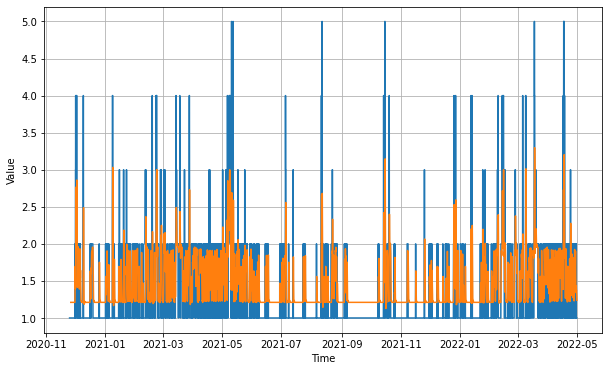

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plot_series(time_train[window_size:], rnn_forecast)

In [ ]:
rnn_forecast_val = model_forecast(model_2, x_valid[..., np.newaxis], window_size)
rnn_forecast_val = rnn_forecast_val[0:-1, -1, 0]

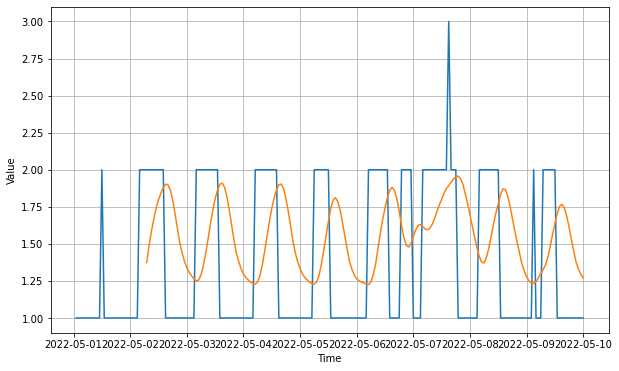

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid[window_size:], rnn_forecast_val)

In [ ]:
mean_absolute_error(x_valid[-156:], rnn_forecast_val)

0.4924437342545925

In [ ]:
accuracy_score(x_valid[-156:], np.round(rnn_forecast_val))

0.5128205128205128

In [ ]:
df['aqi']

2020-11-25 01:00:00    1.0
2020-11-25 02:00:00    1.0
2020-11-25 03:00:00    1.0
2020-11-25 04:00:00    1.0
2020-11-25 05:00:00    1.0
                      ... 
2022-04-30 20:00:00    1.0
2022-04-30 21:00:00    1.0
2022-04-30 22:00:00    1.0
2022-04-30 23:00:00    1.0
2022-05-01 00:00:00    1.0
Freq: H, Name: aqi, Length: 12528, dtype: float64

In [ ]:
x_train

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
model.save('drive/Mylstm_conv')

INFO:tensorflow:Assets written to: lstm_conv/assets


INFO:tensorflow:Assets written to: lstm_conv/assets


In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/lstm_conv')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          832       
                                                                 
 lstm (LSTM)                 (None, None, 64)          24832     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 5)           55        
                                                                 
Total params: 61,003
Trainable params: 61,003
Non-traina

In [ ]:
future['lstm_conv'] = [0].append(inv_to_cat(model_forecast(model, x_valid, window_size)))

ValueError: ignored

In [ ]:
df['lstm_conv_model'] = model_forecast(model, x_train, window_size)

In [ ]:
plt.figure(figsize=(15,7))
future.aqi.plot()
future.lstm_conv.plot(color='r')
plt.ylabel('Aqi')
plt.show()